Experiment with OpenCV for finding the pool table edges within an image

In [53]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from Utils import *
import copy

Generating Calibration
 rotate=False
 dir=AmcrestCamera/Session3/checkerboards
 Checkerboard file count=1
Loading file ../test/images/AmcrestCamera/Session3/empty43.jpg


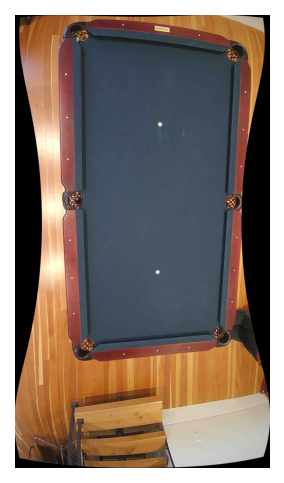

In [54]:
# Do the calibration
dirImages = "AmcrestCamera/Session3"
dirCalImages = dirImages + "/checkerboards"

GenerateCalibration(dirCalImages, False)

# Load the test image
files, dir = FindImageFilesAndDir(subdir=dirImages)
filename = files[0]
filename = "{0}/empty43.jpg".format(dir)
print("Loading file {0}".format(filename))
imageOriginal = cv.imread(filename)
imageOriginal = CalibrateImage(imageOriginal)

ImgShow(imageOriginal,150)
#print(calROI)

imageFeltFlood shape         = (3840, 2160, 3)
imageFeltFloodMaskBrdr shape = (3842, 2162, 1)
imageFeltFloodMask shape    = (3840, 2160, 1)


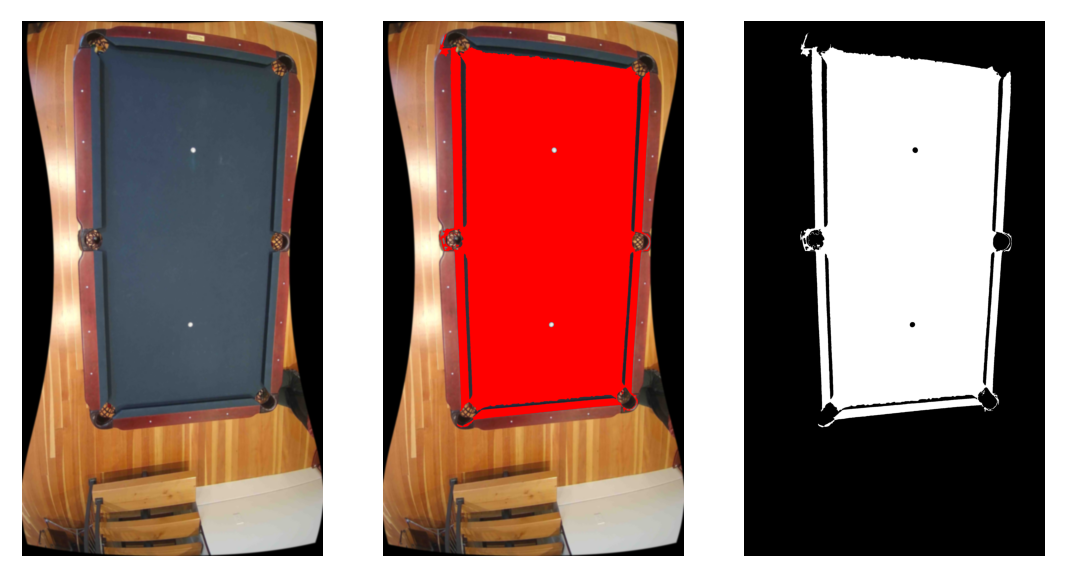

In [55]:
#Find the edges using flood, start with a blur
blur = int(85)
imageBlur = cv.GaussianBlur(imageOriginal, (blur,blur), cv.BORDER_DEFAULT)

imageFeltFlood = imageBlur.copy()
cols = imageFeltFlood.shape[1]
rows = imageFeltFlood.shape[0]
seed = (int(cols / 2), int(rows / 2)) # a point in the middle

imageFeltFloodMaskBrdr = np.zeros((rows+2,cols+2,1), np.uint8)
tolerance = 38.0
diff = (tolerance,tolerance,tolerance)
flags = 8 | cv.FLOODFILL_FIXED_RANGE | 255 << 8
res = cv.floodFill(imageFeltFlood, imageFeltFloodMaskBrdr, seed, (0,0,255),diff,diff, flags)

imageFeltFloodMask = imageFeltFloodMaskBrdr[1:rows+1, 1:cols+1]
print("imageFeltFlood shape         = {0}".format(imageFeltFlood.shape))
print("imageFeltFloodMaskBrdr shape = {0}".format(imageFeltFloodMaskBrdr.shape))
print("imageFeltFloodMask shape    = {0}".format(imageFeltFloodMask.shape))
ImgShow([imageBlur, imageFeltFlood, imageFeltFloodMask], 220)

sizeNew=(2808, 4992)
imageExpanded.shape=(4992, 2808)
imageFeltFloodMask.shape=(3840, 2160, 1)
startY=576 endY=4416 startY=324 startX=2484


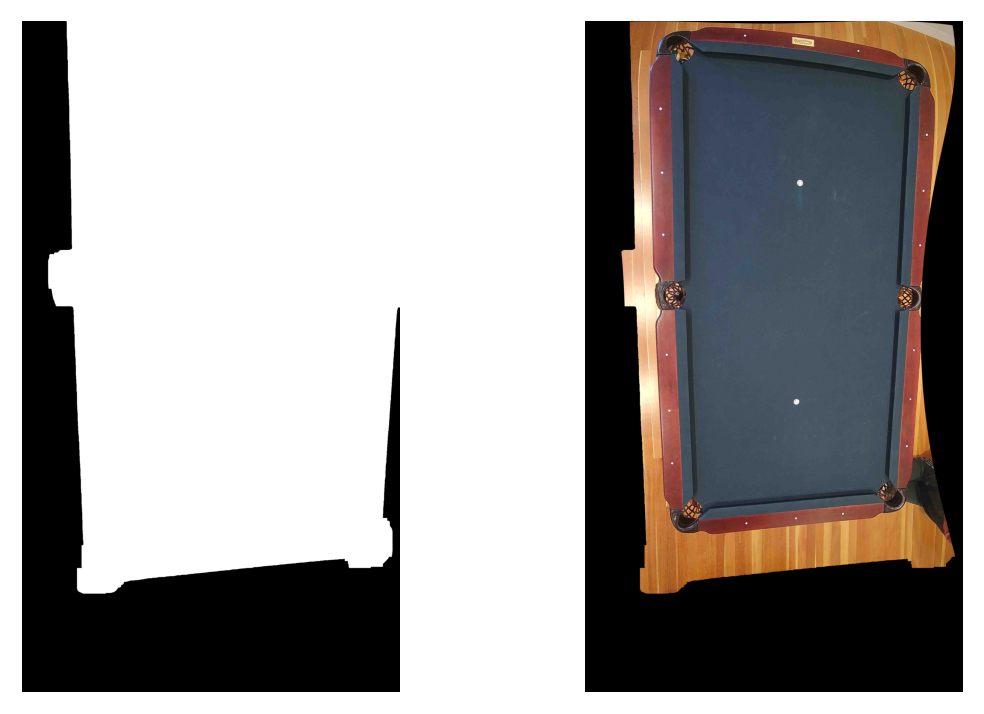

In [56]:
# Brendan's Method
#   Scale the felt up

# Dilate the image 
kernel = np.ones((12,12), np.uint8)
imageFeltFloodMaskDilated = cv.dilate(imageFeltFloodMask, kernel, iterations=8)

# Scale up
factor = 1.3
sizeNew = (int(imageFeltFloodMaskDilated.shape[1] * factor), int(imageFeltFloodMaskDilated.shape[0] * factor))
print("sizeNew={0}".format(sizeNew))
imageExpanded = cv.resize(imageFeltFloodMaskDilated, dsize=sizeNew, interpolation=cv.INTER_AREA)
print("imageExpanded.shape={0}".format(imageExpanded.shape))
print("imageFeltFloodMask.shape={0}".format(imageFeltFloodMask.shape))

# Extract the middle ROI back to the same dimensions
centerX = int(imageExpanded.shape[1] / 2)
centerY = int(imageExpanded.shape[0] / 2)
startY = centerY - int(imageFeltFloodMask.shape[0] / 2)
startX = centerX - int(imageFeltFloodMask.shape[1] / 2)
endY = imageFeltFloodMask.shape[0] + startY
endX = imageFeltFloodMask.shape[1] + startX
print("startY={0} endY={1} startY={2} startX={3}".format(startY, endY, startX, endX))
imageExpandedROI = imageExpanded[startY:endY, startX:endX]

# Apply the mask to the original image using bitwise-and
ret,imageWoodRailsMask = cv.threshold(imageExpandedROI,127,255,cv.THRESH_BINARY)
imageWoodRailsMaskRGB = cv.cvtColor(imageWoodRailsMask, cv.COLOR_GRAY2BGR)
ret,imageWoodRailsMaskRGB = cv.threshold(imageWoodRailsMaskRGB,127,255,cv.THRESH_BINARY)
imageTablePlus = cv.bitwise_and(imageOriginal, imageWoodRailsMaskRGB)

ImgShow([imageExpandedROI, imageTablePlus],222)


Number of approximated corners:  4
Coordinates of approximated corners:
 [[[1183   91]]

 [[1185  130]]

 [[1309  147]]

 [[1307  107]]]


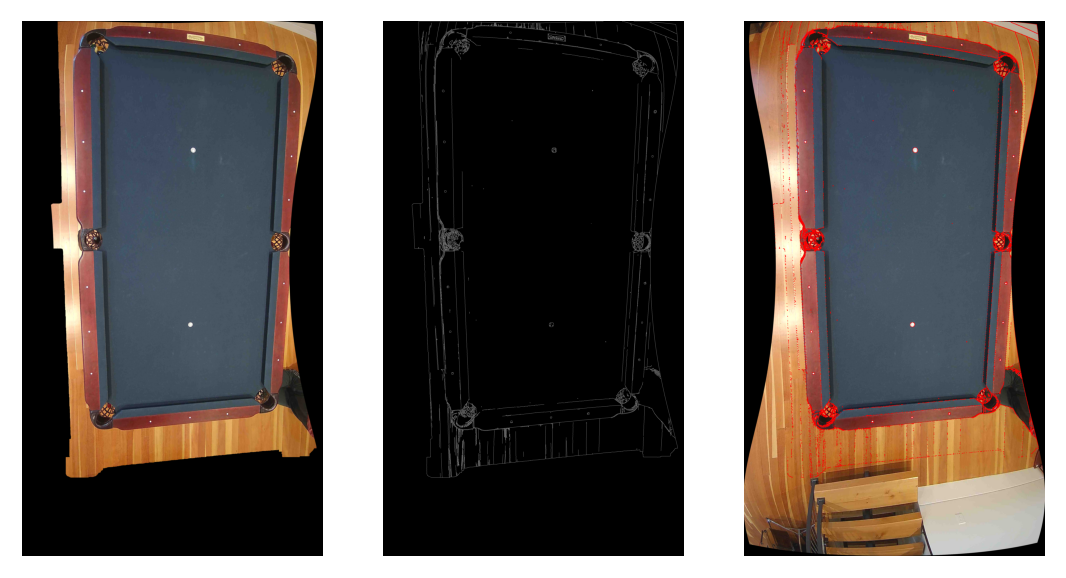

In [77]:
#filters image bilaterally and displays it
bilatImg = cv.bilateralFilter(imageTablePlus, d=5, sigmaColor=175, sigmaSpace=75)

#finds edges of bilaterally filtered image and displays it
imageCanny = cv.Canny(bilatImg, 75, 180)

#gets contours (outlines) for shapes and sorts from largest area to smallest area
contours, hierarchy = cv.findContours(imageCanny, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)

# drawing red contours on the image
imageContours = imageOriginal.copy()
for con in contours:
    cv.drawContours(imageContours, con, -1, (0, 0, 255), 3)

# find the perimeter of the first closed contour
perim = cv.arcLength(contours[0], True)
# setting the precision
epsilon = 0.02*perim
# approximating the contour with a polygon
approxCorners = cv.approxPolyDP(contours[0], epsilon, True)
# check how many vertices has the approximate polygon
approxCornersNumber = len(approxCorners)
print("Number of approximated corners: ", approxCornersNumber)

# can also be used to filter before moving on [if needed]
# i.e. if approxCornersNumber== 4:

# printing the position of the calculated corners
print("Coordinates of approximated corners:\n", approxCorners)

cv.polylines(imageContours, approxCorners, True, (0,255,0), 6)

ImgShow([bilatImg, imageCanny, imageContours],220)

Find the line segments

tableLines count = 107


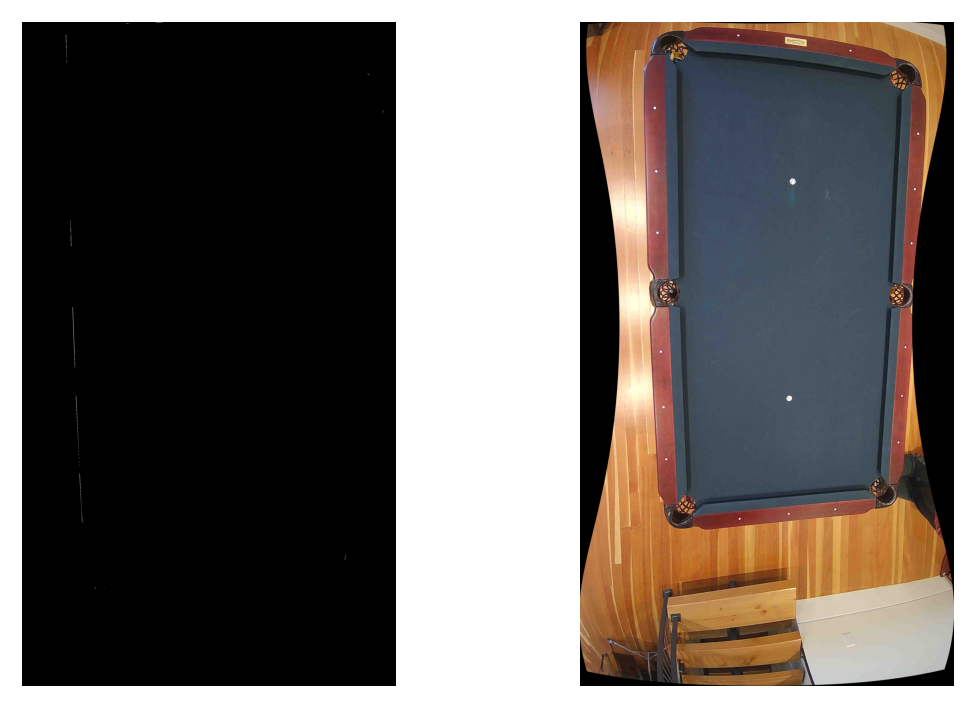

In [120]:
# HoughLinesP for detection
img = imageCanny

cols = imageOriginal.shape[1]
rows = imageOriginal.shape[0]
shortSide = min(cols, rows)
minLineLen = shortSide / 8

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 35  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 150  # minimum number of pixels making up a line
min_line_length = minLineLen
max_line_gap = 60  # maximum gap in pixels between connectable line segments

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
tableLines = cv.HoughLinesP(img, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
print("tableLines count = " + str(len(tableLines)))

# For visualization, draw the lines onto a copy of the image
imageDrawnLines = np.zeros(img.shape[:3],np.uint8)  # creating a blank to draw lines on

pts = []
for line in tableLines:
    for x1,y1,x2,y2 in line:
        pt1 = [x1,y1]
        pt2 = [x2,y2]
        cv.line(imageDrawnLines,pt1,pt2,(255,0,0),3)
        pts.append(pt1)
        pts.append(pt2)

# calculate points for each contour

# Make a simple square to test, with a point in the middle
ptsSquare = [
    [0,0],
    [100,0],
    [100,100],
    [0,100],
    [50,50],
]
#pts = ptsSquare
#print("ptsSquare",ptsSquare)
#print("pts",pts)

# creating convex hull object for each contour
hull = cv.convexHull(np.array(pts), False)
#print("hull=", hull)

# Convert hull to points list
ptsHullRaw = []
for cell in hull:
    ptsHullRaw.append(cell[0])
ptsHull = np.array(ptsHullRaw, dtype=np.int32)

ptsHull.reshape((-1,1,2))
cv.fillConvexPoly(imageDrawnLines, np.array(ptsHull, dtype=np.int32), (0,255,0))

contours = np.array([[250,250], [1150,250], [1150,1150], [250,1150]])
imgTest = imageOriginal.copy()
cv.fillPoly(imageDrawnLines, pts = [contours], color =(0,255,255))
#cv.fillConvexPoly(imageDrawnLines, points = np.array(contours), color =(0,255,255))

ImgShow([imageDrawnLines, imgTest],220)

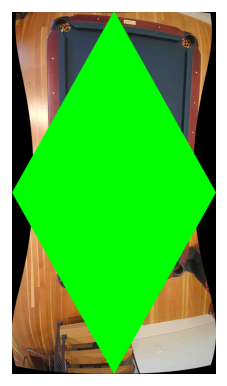

In [118]:
# Test poly
img = imageOriginal.copy()
h,w = img.shape[:2]
cH,cW = int(h/2), int(w/2)
pts=np.array([
    [0,cH],
    [cW,h],
    [w,cH],
    [cW,0]
    ], dtype=np.int32)
pts.reshape((-1,1,2))
#cv.polylines(img,[pts],True,(255,0,0), 10)
cv.fillConvexPoly(img, pts, (0,255,0))

ImgShow(img)

In [ ]:
# Find edge of cloth by angle groupings
class LineP:
    def __init__(self, x1,y1, x2,y2):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        rise = y2 - y1
        run = x2 - x1
        self.m = rise/run
        self.b = y1 - self.m * x1
        
    def angleRad(self):
        return np.arctan(self.m)
    
    def angleDeg(self):
        return self.angleRad() * 180.0 / math.pi
    
    def length(self):
        rise = self.y2 - self.y1
        run = self.x2 - self.x1
        return math.sqrt(rise * rise + run * run)

# Create an array of line objects. Also, we want to finde the 'pseudo-center' of the
# lines. We will do this using the endpoints.
xsum = 0
ysum = 0
lineObjs = []
for line in tableEdgeLines:
    for x1,y1,x2,y2 in line:
        lineObjs.append(LineP(x1,y1,x2,y2))
        xsum += x1
        xsum += x2
        ysum += y1
        ysum += y2

# 'pseudo-center'
center_x = xsum / len(tableEdgeLines) / 2
center_y = ysum / len(tableEdgeLines) / 2

lineObjs.sort(key=lambda s: s.angleDeg()) # sorts using lambda function
#print("After Sort")
#for p in lineObjs:
#    print(p.angleDeg())
        

In [ ]:
# Contours
img = imageOriginal.copy()
imgGray = imageFloodMask.copy()
#imgray = cv.cvtColor(imageFloodMask, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgGray, 127, 255, 0)
contours, b, = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img, contours, -1, (0,255,0),3)
ImgShow([thresh,img])

In [ ]:
# Alternate method using Harris Corner Detection
img = imageFloodMask.copy()

blockSize = 2
ksize = 3
k = 0.04
corners = cv.cornerHarris(img, blockSize, ksize, k)

#result is dilated for marking the corners, not important
corners = cv.dilate(corners, None)

# Threshold for an optimal value, it may vary depending on the image.
imgDrawnCorners = imageOriginal.copy()
#imgDrawnCorners[corners>0.01*corners.max()]=[0,0,255]
ImgShow([imgDrawnCorners, corners])

In [ ]:
img = imageOriginal.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

blockSize = 20
ksize = 21
k = 0.04
imgCorners = cv.cornerHarris(gray,blockSize,ksize,k)
#result is dilated for marking the corners, not important
#dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[imgCorners>0.01*imgCorners.max()]=[0,0,255] # << Brendan, how is this working? There is some implied loop
ImgShow([img, imgCorners],200)

In [ ]:
# Shi-Tomasi corner detection
img = imageOriginal.copy()
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

maxCorners = 20
qualityLevel = 0.01
minDistance = 30
blockSize = 20
corners = cv.goodFeaturesToTrack(gray, maxCorners, qualityLevel, minDistance, cv.noArray, blockSize)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),7,(0,0,255),-1)
    
ImgShow(img, 250)

In [ ]:
import urllib
import cv2 as cv

url = "https://www.cameraftp.com/cameraftp/publish/Camera.aspx/parentID197686853/shareID13469020/Sunset"
rstp = "rtsp://wowzaec2demo.streamlock.net/vod/mp4:BigBuckBunny_115k.mp4"
cap = cv.VideoCapture(rstp)
while True:
    ret,frame=cap.read()
    cv.imshow("RTSP",frame)
    k = cv.waitKey(1)
    if( k == ord('q')):
        break
    
#resp = urllib.urlopen(url)
#img = np.array(bytearray(resp.read))